In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import itertools

In [2]:
def eval_pred(model):
    model_pred = model.predict(test_dataset)
    model_eval = model.evaluate(test_dataset)
    model_groups = model_pred.argmax(axis=-1)
    return model_pred, model_eval, model_groups

In [3]:
num_groups = 6

def pipeline(file, label):
    image = tf.io.read_file(file)
    image_gray = tf.io.decode_jpeg(image, channels=1) 
    image_resized = tf.image.resize(image_gray, [200,200])
    label = tf.one_hot(label, num_groups)
    return image_resized, label

In [4]:
def plot_cm(cm, classes, title):
    plt.imshow(cm, cmap=plt.cm.Greens)
    plt.title(title, fontsize=16)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes)
    plt.yticks(ticks, classes, rotation=90)

    thresh = cm.max() / 2.
    correct = 0
    missed = 0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == j:
            correct =+ cm[i, j]
        else:
            missed =+ cm[i, j]
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Groups', fontsize=14)
    plt.xlabel('Predicted Groups', fontsize=14)
    
    #print(f'Accuracy: {correct / (missed + correct)}')
    # Adapted from Prerak Agarwal [1]

In [5]:
class Model():
    model = ''
    name = ''
    pred = ''
    eval = ''
    groups = ''
    
    def __init__(self, model, model_name):
        self.model = model
        self.name = model_name
        self.pred, self.eval, self.groups = eval_pred(model)

In [6]:
tf.random.set_seed(99)
np.random.seed(99)

In [7]:
groups = {0:'2 to 17',
          1:'18 to 24',
          2:'25 to 29',
          3:'30 to 40',
          4:'40 to 54',
          5:'55 to 80'
         }

In [8]:
file_df = pd.read_csv('files.csv')

In [9]:
train, test = train_test_split(file_df, test_size=0.15)

In [10]:
train_files = list(train['File'])
train_labels = list(train['Group'])

test_files = list(test['File'])
test_labels = list(test['Group'])

In [11]:
X_train_tensor = tf.constant(train_files)
y_train_tensor = tf.constant(train_labels)

X_test_tensor = tf.constant(test_files)
y_test_tensor = tf.constant(test_labels)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))
train_dataset = train_dataset.map(pipeline)
train_dataset = train_dataset.batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test_tensor))
test_dataset = test_dataset.map(pipeline)
test_dataset = test_dataset.batch(64)

In [13]:
alpha = Model(tf.keras.models.load_model('AlexNetAdam1e4_60e'), 'AlexNet Adam 1e4 60e')

829/829 [==============================] - 8s 9ms/step - loss: 1.0625 - accuracy: 0.6875


In [14]:
sigma = Model(tf.keras.models.load_model('AlexNetAdam1e4_20e'), 'AlexNet Adam 1e4 20e')

829/829 [==============================] - 8s 9ms/step - loss: 0.9624 - accuracy: 0.6573


In [15]:
beta = Model(tf.keras.models.load_model('alexNet5e5_45e'), 'AlexNet Adam 5e5 50e')

829/829 [==============================] - 8s 9ms/step - loss: 1.0663 - accuracy: 0.6773


In [16]:
gamma = Model(tf.keras.models.load_model('AlexNetAdaMax1e4_60e'), 'AlexNet Adamax 1e4 60e')

829/829 [==============================] - 8s 9ms/step - loss: 2.2664 - accuracy: 0.6569


In [25]:
delta = Model(tf.keras.models.load_model('nonAugAlexNetSGD1e4_20e'), 'Non Augmented AlexNet SGD 1e4 20e')

829/829 [==============================] - 8s 9ms/step - loss: 2.9499 - accuracy: 0.2159


In [18]:
epsilon = Model(tf.keras.models.load_model('nonAugAlexNetAdam1e4_20e'), 'Non Augmented AlexNet Adam 1e4 20e')

829/829 [==============================] - 8s 9ms/step - loss: 5.7195 - accuracy: 0.2947


In [19]:
zeta = Model(tf.keras.models.load_model('prerakAdam1e4_20e'), 'Prerak Adam 1e4 20e')

829/829 [==============================] - 8s 9ms/step - loss: 1.7243 - accuracy: 0.6177


In [33]:
models = [epsilon, delta, zeta, gamma, beta, sigma, alpha]
names = []
acc = []
loss = []
for model in models:
    names.append(model.name)
    loss.append(model.eval[0])
    acc.append(model.eval[1])
    
data = {'Model Names': names,
        'Loss': loss,
        'Accuracy': acc}

acc_df = pd.DataFrame(data)

In [34]:
acc_df

,Model Names,Loss,Accuracy
0,Non Augmented AlexNet Adam 1e4 20e,5.719541,0.294660
1,Non Augmented AlexNet SGD 1e4 20e,2.949860,0.215868
2,Prerak Adam 1e4 20e,1.724332,0.617689
3,AlexNet Adamax 1e4 60e,2.266387,0.656877
4,AlexNet Adam 5e5 50e,1.066344,0.677292
5,AlexNet Adam 1e4 20e,0.962381,0.657292
6,AlexNet Adam 1e4 60e,1.062538,0.687508


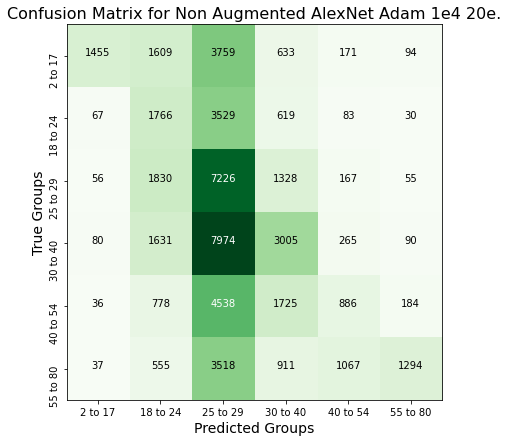

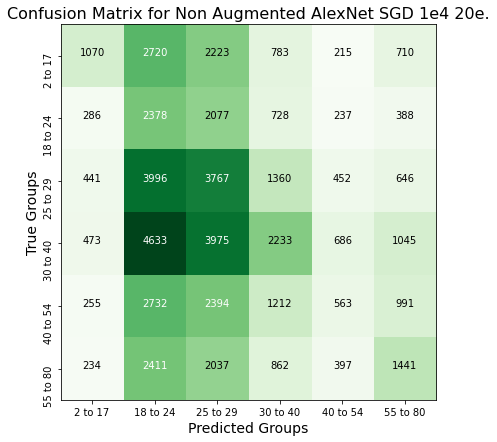

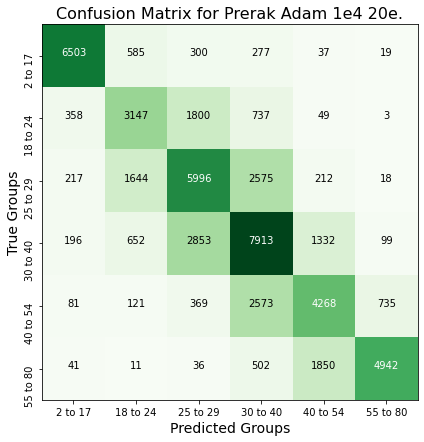

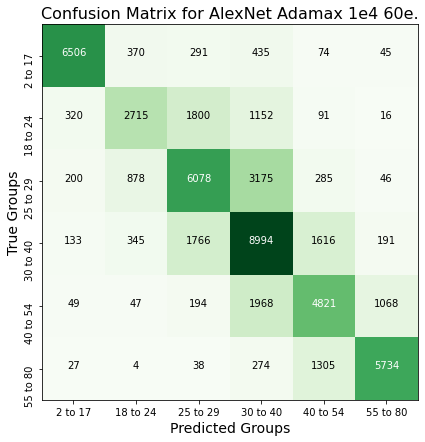

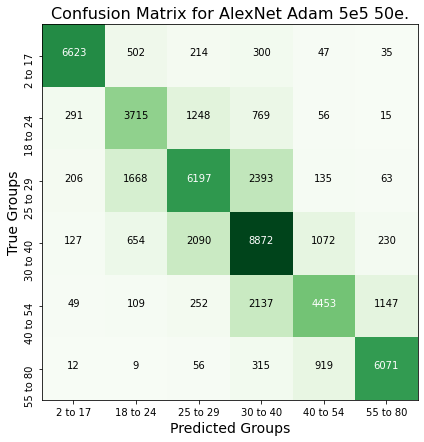

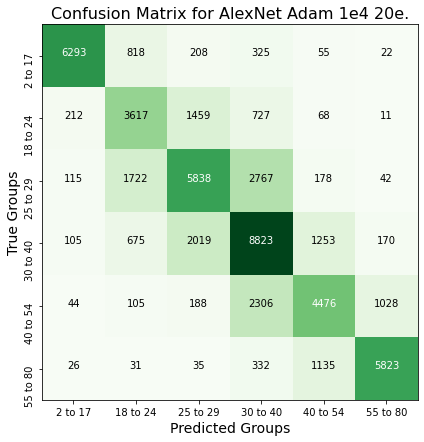

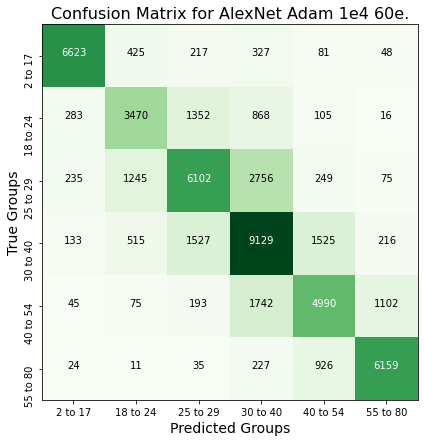

In [32]:
for model in models:
    conf_mat = confusion_matrix(test_labels, model.groups)
    plt.figure(figsize=(12,6))
    plot_cm(conf_mat, list(groups.values()), f'Confusion Matrix for {model.name}.')